In [1]:
import sys

import matplotlib.pyplot as plt

%matplotlib notebook
%matplotlib notebook
## save variables
import pickle
## folder names
from glob import glob
## standard libraries
import numpy as np

#!{sys.executable} -m pip install tensorflow-gpu --user
#!{sys.executable} -m pip install keras --user
import tensorflow as tf
from keras import backend as k

import keras
from keras.optimizers import SGD, Adam
#!{sys.executable} -m pip install hyperas --user
#!{sys.executable} -m pip install networkx==1.11 --user

from hyperas import optim
from hyperas.distributions import choice, uniform, conditional
from hyperopt import Trials, STATUS_OK, tpe

import os.path
import datetime

from dependencies import models
from dependencies import functions

from dependencies.convnet_drawer.convnet_drawer import Model
from dependencies.convnet_drawer.convnet_drawer import Conv2D
from dependencies.convnet_drawer.convnet_drawer import MaxPooling2D as MaxPooling2D_drawer
from dependencies.convnet_drawer.convnet_drawer import Flatten as Flatten_drawer
from dependencies.convnet_drawer.convnet_drawer import Dense as Dense_drawer
from dependencies.convnet_drawer.matplotlib_util import save_model_to_file
from dependencies.convnet_drawer.keras_util import convert_drawer_model

C:\Users\yurin\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Import data

In [2]:
dataset, labels = functions.load_dataset()
with open('variables/labelList.pkl', 'rb') as f: 
        labelList = pickle.load(f)
x_train = dataset['Train']
y_train = labels['Train']
x_test = dataset['Test']
y_test = labels['Test']
x_valid = dataset['Validation']
y_valid = labels['Validation']

# Fitting

## Fitting variables

In [3]:
from functools import partial

# TensorFlow wizardry
config = tf.ConfigProto()
 
# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True
 
# Only allow a total 0.9 of the GPU memory to be allocated
config.gpu_options.per_process_gpu_memory_fraction = 0.8
 
# Create a session with the above options specified.
k.tensorflow_backend.set_session(tf.Session(config=config))

epoch = 15
epochSGD = 30

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.001/epoch, amsgrad=True)
sgd = SGD(lr=0.01, decay=0.01/epochSGD, momentum=0.9, nesterov=True)

top3_acc = partial(keras.metrics.top_k_categorical_accuracy, k=3)
top3_acc.name = 'top3_acc'

dest_directory = 'model_backup/'
if not os.path.exists(dest_directory):
      os.makedirs(dest_directory)

tbCallBack = keras.callbacks.TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)

## Sequential Models

In [ ]:
%%time

print("MODEL1")
cnn = models.model1(x_train,y_train, depth = x_train.shape[3])

cnn.summary()


compiledAdam = cnn.compile(loss="categorical_crossentropy", optimizer=adam, metrics=['accuracy', top3_acc])
fittedAdam = cnn.fit(x_train, y_train,
                     epochs=epoch,
                     validation_data=(x_test, y_test),
                     batch_size=round(x_train.shape[0]/300),
                     shuffle=True,
                     callbacks = [tbCallBack])

compiledSGD = cnn.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=['accuracy', top3_acc])

fittedSGD = cnn.fit(x_train, y_train, 
                epochs=epochSGD, 
                validation_data=(x_test, y_test), 
                batch_size=round(x_train.shape[0]/300), 
                shuffle=True,
                callbacks = [tbCallBack])

fig, ax = plt.subplots()
x = range(epoch)
for key in fittedAdam.history:
    ax.plot(x,fittedAdam.history[key],label=key)
legend = ax.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
for label in legend.get_texts():
    label.set_fontsize('large')

for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width

fig, ax = plt.subplots()
x = range(epochSGD)
for key in fittedSGD.history:
    ax.plot(x,fittedSGD.history[key],label=key)
legend = ax.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
for label in legend.get_texts():
    label.set_fontsize('large')

for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width


plt.show()

name = 'cnn1.bak'
#cnn.save(dest_directory + name)

In [ ]:
%%time
print("\nMODEL3")
cnn = models.model3(x_train,y_train, depth = x_train.shape[3], baseDim = 32)

cnn.summary()


compiledAdam = cnn.compile(loss="categorical_crossentropy", optimizer=adam, metrics=['accuracy', top3_acc])
fittedAdam = cnn.fit(x_train, y_train,
                     epochs=epoch,
                     validation_data=(x_test, y_test),
                     batch_size=round(x_train.shape[0]/200),
                     shuffle=True,
                     callbacks = [tbCallBack])

compiledSGD = cnn.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=['accuracy', top3_acc])

fittedSGD = cnn.fit(x_train, y_train, 
                epochs=epochSGD, 
                validation_data=(x_test, y_test), 
                batch_size=round(x_train.shape[0]/200), 
                shuffle=True,
                callbacks = [tbCallBack])

fig, ax = plt.subplots()
x = range(epoch)
for key in fittedAdam.history:
    ax.plot(x,fittedAdam.history[key],label=key)
legend = ax.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
for label in legend.get_texts():
    label.set_fontsize('large')

for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width

fig, ax = plt.subplots()
x = range(epochSGD)
for key in fittedSGD.history:
    ax.plot(x,fittedSGD.history[key],label=key)
legend = ax.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
for label in legend.get_texts():
    label.set_fontsize('large')

for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
    
plt.show()

name = 'cnn3.bak'
#cnn.save(dest_directory + name)

In [ ]:
%%time
print("\nTINYDARKNET")
cnn = models.tinyDarknet(x_train,y_train, depth = x_train.shape[3], dropout = 0.05)



compiledAdam = cnn.compile(loss="categorical_crossentropy", optimizer=adam, metrics=['accuracy', top3_acc])
fittedAdam = cnn.fit(x_train, y_train,
                     epochs=epoch,
                     validation_data=(x_test, y_test),
                     batch_size=round(x_train.shape[0]/200),
                     shuffle=True,
                     callbacks = [tbCallBack])


compiledSGD = cnn.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=['accuracy', top3_acc])

fittedSGD = cnn.fit(x_train, y_train, 
                epochs=epochSGD, 
                validation_data=(x_test, y_test), 
                batch_size=round(x_train.shape[0]/200), 
                shuffle=True,
                callbacks = [tbCallBack])

fig, ax = plt.subplots()
x = range(epoch)
for key in fittedAdam.history:
    ax.plot(x,fittedAdam.history[key],label=key)
legend = ax.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
for label in legend.get_texts():
    label.set_fontsize('large')

for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width

fig, ax = plt.subplots()
x = range(epochSGD)
for key in fittedSGD.history:
    ax.plot(x,fittedSGD.history[key],label=key)
legend = ax.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
for label in legend.get_texts():
    label.set_fontsize('large')

for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
    
plt.show()

name = 'cnn4.bak'
#cnn.save(dest_directory + name)

In [ ]:
cnn.summary()

In [ ]:
#!tensorboard --logdir Graph/

# Inception

In [5]:
from keras.layers import Input
from keras.layers import Flatten, Dense, Activation, BatchNormalization, Dropout, SpatialDropout2D
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D
from keras import regularizers
from keras.models import Model


def cBN(inputLayer, filt = 64, size = (1,1), padding = 'same', activation = 'relu', regu = 0.0, dropout = 0.05, strides = (1,1)):
    cbn = Conv2D(filt, size, padding=padding, use_bias=False, kernel_regularizer=regularizers.l2(regu), strides = (1,1))(inputLayer)
    cbn = Activation(activation)(cbn)
    #cbn = BatchNormalization(epsilon=1e-05, momentum=0.1, axis=-1)(cbn)
    return cbn

def inception(inputLayer, filt = 64):
    tower_1 = cBN(inputLayer, filt = filt)   
    tower_1 = cBN(tower_1, size = (3,3), filt = filt)

    tower_2 = cBN(inputLayer, filt = filt)
    tower_2 = cBN(tower_2, size = (5,5), filt = filt)

    tower_3 = MaxPooling2D((3,2), strides=(1,1), padding='same')(inputLayer)
    tower_3 = cBN(tower_3, filt = filt)
    
    #tower_4 = cBN(inputLayer)

    output = keras.layers.concatenate([tower_1, tower_2, tower_3], axis = 3)
    return output

## Single output

In [ ]:
input_img = Input(name = 'input', shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3]))

#output = inception(input_img, filt = 20)
output = inception(input_img, filt = 30)

output = MaxPooling2D(pool_size=(3,2), padding='same')(output)
output = SpatialDropout2D(0.15)(output)

#output = inception(output,filt = 30)
output = inception(output, filt = 40)

output = MaxPooling2D(pool_size=(3,2), padding='same')(output)
output = SpatialDropout2D(0.15)(output)

#output = inception(output, filt = 40)
output = inception(output, filt = 60)

output = MaxPooling2D(pool_size=(3,2), padding='same')(output)
output = SpatialDropout2D(0.15)(output)

#output = inception(output, filt = 60)
output = inception(output, filt = 100)

output = GlobalAveragePooling2D()(output)
#output = Dropout(0.2)(output)

output = Dense(100)(output)
#output = BatchNormalization(epsilon=1e-05, momentum=0.1)(output)
output = Activation('relu')(output)
output = Dropout(0.4)(output)
output = Dense(y_train.shape[1], name = 'output2', activation='softmax')(output)

In [ ]:
cnn = Model(inputs = input_img, outputs = output)
validation_data=({'input': x_test}, {'output2': y_test})
cnn.summary()

In [ ]:
compiledAdam = cnn.compile(loss="categorical_crossentropy", optimizer=adam, metrics=['categorical_accuracy', top3_acc], loss_weights={'output2' : 1.})
fittedAdam = cnn.fit(x_train,  y_train,
                     epochs=epoch,
                     batch_size=round(x_train.shape[0]/400),
                     shuffle=True,
                     validation_data=validation_data, 
                     callbacks = [tbCallBack])
compiledSGD = cnn.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=['accuracy', top3_acc], loss_weights={'output2' : 1.})
fittedSGD = cnn.fit(x_train, y_train,
                     epochs=epochSGD,
                     batch_size=round(x_train.shape[0]/400),
                     validation_data=validation_data,
                     shuffle=True,
                     callbacks = [tbCallBack])

## Multiple input

In [6]:
mfcc = True
from keras.layers.advanced_activations import LeakyReLU
def lin_inception(inputLayer, filt = 64, base = 3):
    tower_1 = cBN(inputLayer, filt = filt)   
    tower_1 = cBN(tower_1, size = (base,1), filt = filt)

    tower_2 = cBN(inputLayer, filt = filt)
    tower_2 = cBN(tower_2, size = (base+1,1), filt = filt)

    tower_3 = cBN(inputLayer, filt = filt)
    tower_3 = cBN(tower_3, filt = filt, size = (base+2,1))
    
    output = keras.layers.concatenate([tower_1, tower_2, tower_3], axis = 3)
    return output

def inception(inputLayer, filt = 64, base = 3):
    tower_1 = cBN(inputLayer, filt = filt)   
    tower_1 = cBN(tower_1, size = (base,base), filt = filt)

    tower_2 = cBN(inputLayer, filt = filt)
    tower_2 = cBN(tower_2, size = (base+2,base+2), filt = filt)
    
    tower_3 = MaxPooling2D((3,3), strides=(1,1), padding='same')(inputLayer)
    tower_3 = cBN(tower_3, filt = filt)
    output = keras.layers.concatenate([tower_1, tower_2, tower_3], axis = 3)
    return output

def singleInputMFCC(x_train, name, mfcc = True):
    single_input = Input(name = name, shape = (x_train.shape[1], x_train.shape[2], 1))
    if mfcc:
        output = Conv2D(120, (3,round(x_train.shape[2])))(single_input)
        output = lin_inception(output, filt = 80, base = 3)
        '''
    else:
        output = Conv2D(120, (6,6))(single_input)
        output = inception(output, filt = 80, base = 3)
    '''
    else:
        output = Conv2D(32, (3,3), padding = "same")(single_input)
        output = LeakyReLU(alpha=.1)(output)
        output = Conv2D(16, (3,3), padding = "same")(output)
        output = LeakyReLU(alpha=.1)(output)
        output = MaxPooling2D(pool_size=(2,2))(output)
        output = Conv2D(16, (1,1), padding = "same")(output)
        output = LeakyReLU(alpha=.1)(output)
        output = Conv2D(64, (3,3), padding = "same")(output)
        output = LeakyReLU(alpha=.1)(output)
        output = Conv2D(16, (1,1), padding = "same")(output)
        output = LeakyReLU(alpha=.1)(output)
        output = Conv2D(64, (3,3), padding = "same")(output)
        output = LeakyReLU(alpha=.1)(output)
        output = MaxPooling2D(pool_size=(2,2))(output)
        output = Conv2D(16, (1,1), padding = "same")(output)
        output = LeakyReLU(alpha=.1)(output)
        output = Conv2D(64, (3,3), padding = "same")(output)
        output = LeakyReLU(alpha=.1)(output)
        output = Conv2D(16, (1,1), padding = "same")(output)
        output = LeakyReLU(alpha=.1)(output)
        output = Conv2D(64, (3,3), padding = "same")(output)
        output = LeakyReLU(alpha=.1)(output)
        #output = MaxPooling2D(pool_size=(5,3))(output)
        #output = inception(output, filt = 40, base = 3)       
    
    return single_input, output
def firstConcat(x_train, mfcc = True):
    first, first_output = singleInputMFCC(x_train,'first', mfcc = mfcc)
    second, second_output = singleInputMFCC(x_train,'second', mfcc = mfcc)
    third, third_output = singleInputMFCC(x_train,'third', mfcc = mfcc)
    concat = keras.layers.concatenate([first_output, second_output, third_output], axis = 3)
    return first, second, third, concat

first_input, second_input, third_input, concat = firstConcat(x_train, mfcc = mfcc)

if mfcc:
    output = MaxPooling2D(pool_size=(3,1), padding='same')(concat)
    output = Dropout(0.05)(output)
    output = lin_inception(output, filt = 80, base = 3)
else:
    output = MaxPooling2D(pool_size=(5,3), padding='same')(concat)
    #output = Dropout(0.15)(output)
    output = inception(output, filt = 60, base = 2)
    #output = MaxPooling2D(pool_size=(3,3), padding='same')(output)
#output = lin_inception(output, filt = 80, base = 3)
if mfcc:
    output = AveragePooling2D((11,1))(output)
    output = Flatten()(output)
else:
    output = GlobalAveragePooling2D()(output)
#output = cBN(output, filt = 64)

output = Dense(70)(output)
output = Activation('relu')(output)
output = Dropout(0.4)(output)

output = Dense(y_train.shape[1], name = 'output', activation='softmax')(output)



In [7]:
cnn = Model(inputs = [first_input, second_input, third_input], outputs = output)
validation_data=({'first': x_valid[:,:,:,0, np.newaxis], 'second': x_valid[:,:,:,1, np.newaxis], 'third': x_valid[:,:,:,2, np.newaxis]}, {'output': y_valid})

cnn.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
first (InputLayer)              (None, 99, 14, 1)    0                                            
__________________________________________________________________________________________________
second (InputLayer)             (None, 99, 14, 1)    0                                            
__________________________________________________________________________________________________
third (InputLayer)              (None, 99, 14, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 97, 1, 120)   5160        first[0][0]                      
__________________________________________________________________________________________________
conv2d_8 (

In [8]:
compiledAdam = cnn.compile(loss="categorical_crossentropy", optimizer=adam, metrics=['accuracy', top3_acc], loss_weights={'output' : 1.})
fittedAdam = cnn.fit([x_train[:,:,:,0, np.newaxis], x_train[:,:,:,1, np.newaxis], x_train[:,:,:,2, np.newaxis]],  y_train,
                     epochs=epoch,
                     batch_size=round(x_train.shape[0]/400),
                     shuffle=True,
                     validation_data=validation_data, 
                     callbacks = [tbCallBack])

compiledSGD = cnn.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=['accuracy', top3_acc], loss_weights={'output' : 1.})
fittedSGD = cnn.fit([x_train[:,:,:,0, np.newaxis], x_train[:,:,:,1, np.newaxis], x_train[:,:,:,2, np.newaxis]],  y_train,
                     epochs=epochSGD,
                     batch_size=round(x_train.shape[0]/400),
                     shuffle=True,
                     validation_data=validation_data, 
                     callbacks = [tbCallBack])

Train on 62719 samples, validate on 2047 samples
Epoch 1/15
62719/62719 [==============================] - 19s 298us/step - loss: 1.2099 - acc: 0.5860 - top3_acc: 0.8217 - val_loss: 0.4109 - val_acc: 0.8666 - val_top3_acc: 0.9717
Epoch 2/15
62719/62719 [==============================] - 14s 224us/step - loss: 0.6992 - acc: 0.7680 - top3_acc: 0.9263 - val_loss: 0.2381 - val_acc: 0.9292 - val_top3_acc: 0.9853
Epoch 3/15
62719/62719 [==============================] - 14s 224us/step - loss: 0.5890 - acc: 0.8070 - top3_acc: 0.9405 - val_loss: 0.2146 - val_acc: 0.9350 - val_top3_acc: 0.9853
Epoch 4/15
62719/62719 [==============================] - 14s 224us/step - loss: 0.5281 - acc: 0.8262 - top3_acc: 0.9478 - val_loss: 0.1961 - val_acc: 0.9365 - val_top3_acc: 0.9858
Epoch 5/15
62719/62719 [==============================] - 14s 225us/step - loss: 0.4755 - acc: 0.8422 - top3_acc: 0.9542 - val_loss: 0.1892 - val_acc: 0.9394 - val_top3_acc: 0.9868
Epoch 6/15
62719/62719 [======================

KeyboardInterrupt: 

## Multiple output

In [ ]:
def extraClassifier(name, inputLayer, outputShape):
    output0 = GlobalAveragePooling2D()(inputLayer)
    output0 = Dense(100, activation = 'relu')(output0)
    output0 = Dropout(0.7)(output0)
    output0 = Dense( outputShape, name = name, activation='softmax')(output0)
    return output0

In [ ]:
input_img = Input(name = 'input', shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3]))

output = cBN(input_img)
output = cBN(output, size = (3,3))
output = cBN(output)
output = cBN(output, size = (3,3))

output = MaxPooling2D(pool_size=(3,2), padding='same')(output)

output = inception(output)
output0 = extraClassifier('output0', output, y_train.shape[1])
#output = inception(output)

output = MaxPooling2D(pool_size=(3,2), padding='same')(output)

output = inception(output)
output1 = extraClassifier('output1',output, y_train.shape[1])
output = inception(output)

#output = cBN(output)
output = GlobalAveragePooling2D()(output)

#output = Dense(90, activation = 'relu')(output)
output = Dropout(0.5)(output)
output2 = Dense(y_train.shape[1], name = 'output2', activation='softmax')(output)

In [ ]:
cnn = Model(inputs = input_img, outputs = [output2, output1, output0])
validation_data=({'input': x_test}, {'output0': y_test, 'output1': y_test, 'output2': y_test})
cnn.summary()

In [ ]:
compiledAdam = cnn.compile(loss="categorical_crossentropy", optimizer=adam, metrics=['accuracy', top3_acc ], loss_weights={'output0': 1., 'output1': 1., 'output2' : 1.})
fittedAdam = cnn.fit(x_train, [y_train, y_train, y_train],
                     epochs=epoch,
                     batch_size=round(x_train.shape[0]/400),
                     shuffle=True,
                     validation_data=validation_data, 
                     callbacks = [tbCallBack])

In [ ]:
compiledSGD = cnn.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=['accuracy', top3_acc], loss_weights={'output0': 0.4, 'output1': 0.7, 'output2' : 1.})
fittedSGD = cnn.fit(x_train, [y_train, y_train, y_train],
                     epochs=epochSGD,
                     batch_size=round(x_train.shape[0]/400),
                     validation_data=validation_data,
                     shuffle=True,
                     callbacks = [tbCallBack])

# Score

In [9]:
from itertools import product

def w_categorical_crossentropy(y_true, y_pred, weights):
    nb_cl = len(weights)
    final_mask = k.zeros_like(y_pred[:, 0])
    y_pred_max = k.max(y_pred, axis=1)
    y_pred_max = k.reshape(y_pred_max, (k.shape(y_pred)[0], 1))
    y_pred_max_mat = k.cast(k.equal(y_pred, y_pred_max), k.floatx())
    for c_p, c_t in product(range(nb_cl), range(nb_cl)):
        final_mask += (weights[c_t, c_p] * y_pred_max_mat[:, c_p] * y_true[:, c_t])
    return k.categorical_crossentropy(y_pred, y_true) * final_mask

def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    
    weights = k.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= k.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = k.clip(y_pred, k.epsilon(), 1 - k.epsilon())
        # calc
        loss = y_true * k.log(y_pred) * weights
        loss = -k.sum(loss, -1)
        return loss
    
    return loss

<IPython.core.display.Javascript object>


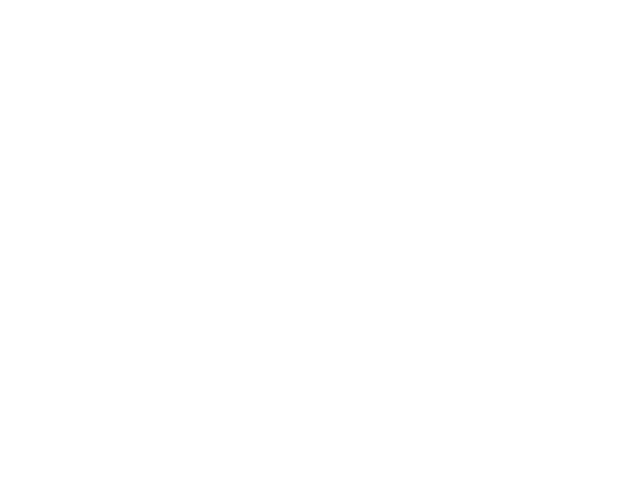

<IPython.core.display.Javascript object>


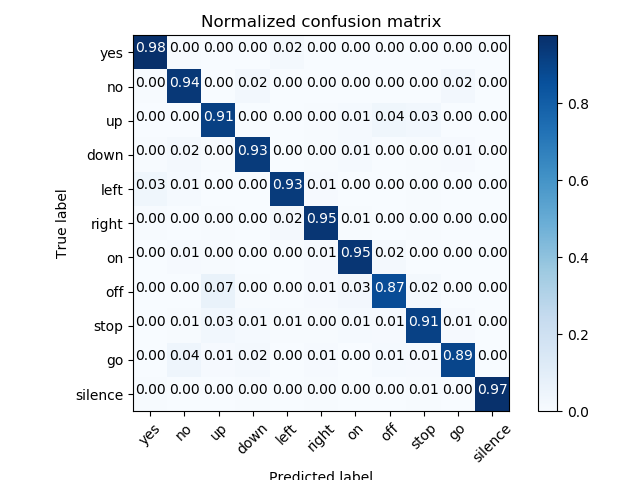

Normalized confusion matrix
4766/4766 [==============================] - 1s 133us/step
Precision:  93.22 %


In [22]:
#find prediction with test data
%matplotlib notebook
plt.figure()
preds = cnn.predict([x_test[:,:,:,0, np.newaxis], x_test[:,:,:,1, np.newaxis], x_test[:,:,:,2, np.newaxis]])
#Plot normalized confusion matrix
plt.figure()
functions.plot_confusion_matrix(preds, y_test, classes=labelList, normalize=True,
                      title='Normalized confusion matrix')
precision = cnn.evaluate([x_test[:,:,:,0, np.newaxis], x_test[:,:,:,1, np.newaxis], x_test[:,:,:,2, np.newaxis]],  y_test)
print ("Precision: ", round(precision[1]*100,2),"%")

#print(list(used))

<IPython.core.display.Javascript object>


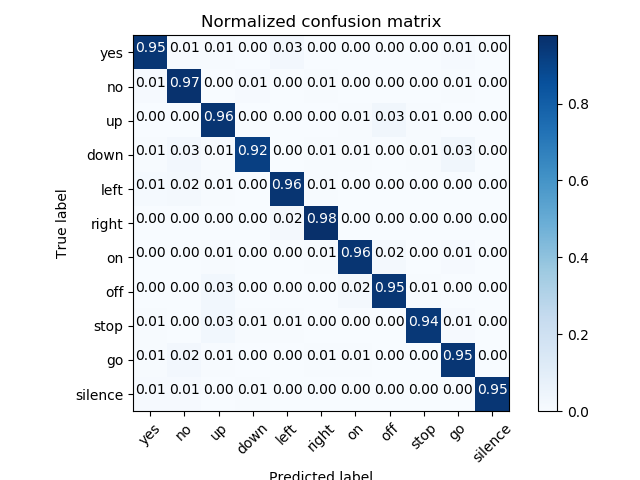

Normalized confusion matrix
[[1.01 1.97 1.97 1.98 1.93 1.98 1.98 1.98 1.98 1.96 1.98]
 [1.96 1.   1.98 1.96 1.98 1.97 1.98 1.98 1.98 1.97 1.98]
 [1.98 1.98 1.01 1.98 1.98 1.98 1.97 1.92 1.97 1.98 1.98]
 [1.97 1.93 1.97 1.03 1.98 1.97 1.97 1.98 1.97 1.92 1.98]
 [1.95 1.94 1.96 1.98 1.01 1.96 1.98 1.98 1.98 1.98 1.98]
 [1.98 1.98 1.98 1.98 1.93 1.   1.98 1.98 1.98 1.98 1.98]
 [1.98 1.98 1.97 1.98 1.98 1.97 1.01 1.93 1.98 1.96 1.98]
 [1.98 1.98 1.92 1.98 1.98 1.98 1.95 1.01 1.97 1.98 1.98]
 [1.97 1.98 1.92 1.97 1.97 1.98 1.98 1.98 1.02 1.96 1.98]
 [1.97 1.93 1.97 1.98 1.98 1.97 1.97 1.98 1.98 1.01 1.98]
 [1.95 1.95 1.98 1.96 1.97 1.98 1.97 1.97 1.97 1.97 1.01]]
[0.05 0.03 0.04 0.08 0.04 0.02 0.04 0.05 0.06 0.05 0.05]


In [21]:
preds = cnn.predict([x_valid[:,:,:,0, np.newaxis], x_valid[:,:,:,1, np.newaxis], x_valid[:,:,:,2, np.newaxis]])
plt.figure()
cm = functions.plot_confusion_matrix(preds, y_valid, classes=labelList, normalize=True,
                      title='Normalized confusion matrix', plot = True)
weights = (1 + cm)
weights /= np.max(weights)
print(weights**(-1))
ncce = partial(w_categorical_crossentropy, weights=weights)
ncce.__name__ ='w_categorical_crossentropy'

weights = np.diagonal(1 - cm).copy()
#weights /= np.max(weights)
ncce1 = weighted_categorical_crossentropy(weights)
ncce1.__name__ ='w_categorical_crossentropy'

print(weights)

In [ ]:
compiledSGD = cnn.compile(loss=ncce1, optimizer=sgd, metrics=['accuracy', top3_acc], loss_weights={'output': 1.})
fittedSGD = cnn.fit([x_train[:,:,:,0, np.newaxis], x_train[:,:,:,1, np.newaxis], x_train[:,:,:,2, np.newaxis]],  y_train,
                     epochs=epochSGD,
                     batch_size=round(x_train.shape[0]/400),
                     shuffle=True,
                     validation_data=validation_data, 
                     callbacks = [tbCallBack])

In [ ]:
preds = cnn.predict(x_test)
#Plot normalized confusion matrix
plt.figure()
functions.plot_confusion_matrix(preds, y_test, classes=labelList, normalize=True,
                      title='Normalized confusion matrix')
precision = cnn.evaluate(x_test,  y_test)
#print ("Precision: ", round(precision*100,2),"%")

In [ ]:
#

# Output of conv2D

In [ ]:
cnn_copy = Sequential()
cnn_copy.add(cnn.layers[0])
result = cnn_copy.predict(x_test)


In [ ]:
plt.figure()
plt.imshow(result[0,:,:,0])

# Save Model

In [ ]:
dest_directory = 'model_backup/'
if not os.path.exists(dest_directory):
      os.makedirs(dest_directory)
name = 'cnn.bak'
cnn.save(dest_directory + name)

#bak = load_model(dest_directory + name)


In [ ]:
model = Model(input_shape=(x_train.shape[1], x_train.shape[2],1))
model.add(Conv2D(100, (4,4),  strides = (1,1), padding="valid"))
model.add(Conv2D(100, (4,2),  strides = (1,1), padding="valid"))
model.add(MaxPooling2D_drawer(pool_size=(3,3)))
model.add(Conv2D(128, (4,2),  strides = (1,1), padding="valid"))
model.add(Conv2D(128, (5,2),  strides = (1,1), padding="valid"))
model.add(MaxPooling2D_drawer(pool_size=(4,1)))
model.add(Flatten_drawer())
model.add(Dense_drawer(100))
model.add(Dense_drawer(y_train.shape[1]))

#save to pdf
save_model_to_file(model, "example.pdf")

# Looking for hyperparameters

In [ ]:
from keras.activations import softmax
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Flatten, Dropout, Convolution2D, MaxPooling2D, AveragePooling2D, BatchNormalization
trials = Trials()
best_run, best_model = optim.minimize(model=functions.create_model, 
                                      data=functions.data,
                                      algo=tpe.suggest,
                                      max_evals=100,
                                      trials=trials,
                                      notebook_name='Processing')

In [ ]:
dest_directory = 'model_backup/'
'''
best_model = load_model(dest_directory + 'best_model.bak')

with open(dest_directory+'best_run.pkl', 'rb') as f:  
    best_run = pickle.load(f)    
'''
print("Evalutation of best performing model:")
print(best_model.evaluate(x_test, y_test))
print("Best performing model chosen hyper-parameters:")
print(best_run)
best_model.summary()




now = datetime.datetime.now()
dest_directory_temp =dest_directory + 'bestModel('+now.strftime("%m-%d %H.%M")+")"
if not os.path.exists(dest_directory_temp):
      os.makedirs(dest_directory_temp)
best_model.save(dest_directory_temp + '/best_model.bak')

with open(dest_directory_temp + '/best_run.pkl', 'wb') as f:  
    pickle.dump(best_run, f)



In [ ]:
trials.best_trial